- Source: https://github.com/MarvinLSJ/LSTM-siamese
- Download spanish embeddings from: https://fasttext.cc/docs/en/pretrained-vectors.html

## Brief introduction

### Model Intro:

To do

### How to use:

Main file is **'siamese.py'**, the configuration file is **'siamese-config.yaml'**.  

#### 1. Initialization:
    
    First run with the original dataset, you should input parameters **'--config siamese-config.yaml'**, while configuring **make_dict** and **data_preprocessing** as **True**, it will make the embedding and preprocess the original dataset, saved them for future usage.  


#### 2. Model:

**Tuning Parameters**:
    
    a. Classifier
    
       fc_dim: classifier fully connected layer size, 
    
    b. Encoder
           
       hidden_size: lstm hidden size
       num_layers: lstm layer 
       bidirectional: bidirectional lstm can get more info
       dropout: avoid overfitting
        
    c. Embedding
           
       embedding_freeze: Set it to false, then the embedding will participate backpropogation. Not so good from my experience, especially small training dataset.
    
    d. Other
    
**Structure**:
    
    a. Classifier
        
        fc layers, non-linear fc layers(add ReLU)
    
    b. Encoder 
        
        Features generating method, current method is (v1, v2, abs(v1-v2), v1*v2), more features with different vector distance measurement?
        
    
#### 3. Training

    a. Optimizer
    
       Default SGD, lots of optimizer in torch.

    b. Learning rate
    
       It should be small enough to avoid oscillation. Furthur exploration can be dynamic lr clipping.
        
    c. Other

### To do list:

    1. Early stopping
    
    2. Dynamic learning rate

### Configuration 

In [16]:
config = {
    'experiment_name': 'siamese-baseline',
    'task': 'train',
    'make_dict': False,  # use pre-processed embeddings (from pickle)
    'data_preprocessing': True,

    'ckpt_dir': 'ckpt/',

    'training':{
        'num_epochs': 1, #20,   # decreased for debugging
        'learning_rate': 0.01,
        'optimizer': 'sgd'
    },
    
    'embedding':{
        'full_embedding_path': '/Volumes/data/repo/data/fasttext/wiki.es.vec',  # fastText embeddings (change path!)
        'cur_embedding_path': 'input/embedding.pkl',
    },
        
    'model':{
        'fc_dim': 100,
        'name': 'siamese',
        'embed_size': 300,
        'batch_size': 1,
        'embedding_freeze': False,
        'encoder':{
            'hidden_size': 150,
            'num_layers': 1,
            'bidirectional': False,
            'dropout': 0.0,
        },  
    },   
    
    'result':{
        'filename':'result.txt',
        'filepath':'res/',
    }
}

## Code

In [17]:
#coding=utf-8
import os
import yaml
import argparse
from datetime import datetime

import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader

# utils
from siamese.utils import get_embedding, load_embed, save_embed, data_preprocessing
# data
from siamese.data import myDS, mytestDS
# model
from siamese.model import Siamese_lstm

### Data Pre-processing

**Preprocess the original data:** 

    1. Remove spanish punctuations, convert unique spanish uppercase letters into lower case since .lower() can not be applied to spanish uppercase letters.      
        E.g. Remove ¡,¿; Convert Á to á, Ó to ó, Ú to ú, É to é, Í to í.  
        
    2. Remove spanish stopwords.  
    
    3. After stopwords removal, there are some empty sentences, drop those sentences pairs.

Details in **utils.py** function: **data_preprocessing**  

In [18]:
""" Data Preprocessing """

if config['data_preprocessing']:
    print('Pre-processing Original Data ...')
    data_preprocessing()
    print('Data Pre-processing Done!')

Pre-processing Original Data ...
dirty sample count: 73
positive dirty training sample: 5
negative dirty training sample: 68
Train sample count: 21327 Test sample count: 4998
Data Pre-processing Done!


### Data Spliting and Loading

**Split train_data into train and valid, load them into myDS**:
    
    1. Split train_data into train, valid by 0.8
    
    2. Load them into myDS, with vocabulary of all train_data and test_data.
    
Details in **data.py** class **myDS** and **Vocab**

In [19]:
""" Read Data """

train_data = pd.read_csv('input/cleaned_train.csv')

train_data = train_data[:500] # decreased for debugging

test_data = pd.read_csv('input/cleaned_test.csv')

# split dataset
msk = np.random.rand(len(train_data)) < 0.8
train = train_data[msk]
valid = train_data[~msk]
all_sents = train_data['s1'].tolist() + train_data['s2'].tolist() + test_data['s1'].tolist() + test_data['s2'].tolist()

# dataset
trainDS = myDS(train, all_sents)
validDS = myDS(valid, all_sents)

print('Data size:',train_data.shape[0], test_data.shape[0])

Data size: 500 4998


### Get Embedding

**Generating or loading saved embeddings**

    1. Retrieving known words' embeddings in vocabulary and initialize unknown words' embeddings including <sos>,<eos>,<unk>,<pad>
    
    2. Loading existing embeddings if there is one.
    
    3. Get embedding weight_matrix and convert to nn.Embeddings, add to config.
    
Details in **utils.py** function **get_embedding**

In [5]:
""" Get Embedding """

full_embed_path = config['embedding']['full_embedding_path']
cur_embed_path = config['embedding']['cur_embedding_path']

if os.path.exists(cur_embed_path) and not config['make_dict']:
    embed_dict = load_embed(cur_embed_path)
    print('Loaded existing embedding.')
else:
    print('Making embedding...')
    embed_dict = get_embedding(trainDS.vocab._id2word, full_embed_path)
    save_embed(embed_dict,cur_embed_path)
    print('Saved generated embedding.')


Loaded existing embedding.


Make embedding weight_matrix in the same order of embed_dict, which can be refered to words embeddings when the sentences are converted into ids. 

In [6]:
vocab_size = len(embed_dict)
# initialize nn embedding
embedding = nn.Embedding(vocab_size, config['model']['embed_size'])
embed_list = []
for word in trainDS.vocab._id2word:
    embed_list.append(embed_dict[word])
weight_matrix = np.array(embed_list)
# pass weights to nn embedding
embedding.weight = nn.Parameter(torch.from_numpy(weight_matrix).type(torch.FloatTensor), requires_grad = False)

Add to config.

In [7]:
# embedding
config['embedding_matrix'] = embedding
config['vocab_size'] = len(embed_dict)

In [8]:
from siamese.model import LSTMEncoder
config

#encoder = LSTMEncoder(config)

{'experiment_name': 'siamese-baseline',
 'task': 'train',
 'make_dict': False,
 'data_preprocessing': True,
 'ckpt_dir': 'ckpt/',
 'training': {'num_epochs': 20, 'learning_rate': 0.01, 'optimizer': 'sgd'},
 'embedding': {'full_embedding_path': '/Volumes/data/repo/data/fasttext/wiki.es.vec',
  'cur_embedding_path': 'input/embedding.pkl'},
 'model': {'fc_dim': 100,
  'name': 'siamese',
  'embed_size': 300,
  'batch_size': 1,
  'embedding_freeze': False,
  'encoder': {'hidden_size': 150,
   'num_layers': 1,
   'bidirectional': False,
   'dropout': 0.0}},
 'result': {'filename': 'result.txt', 'filepath': 'res/'},
 'embedding_matrix': Embedding(5772, 300),
 'vocab_size': 5772}

### Model Preparation

In [9]:
# model
siamese = Siamese_lstm(config)

#### Loss function
Considering the amounts of Pos and Neg samples are roughly 1:3, thus conpensate the pos samples on loss weights, set the loss weight as 1:3 (Neg:Pos)

In [10]:
# loss func
loss_weights = Variable(torch.FloatTensor([1, 3]))
if torch.cuda.is_available():
    loss_weights = loss_weights.cuda()
criterion = torch.nn.CrossEntropyLoss(loss_weights)

#### Optimizer

Using SGD as default, learning rate 0.01.  

Possible options: adam, adadelta, rmsprop

In [11]:
# optimizer
learning_rate = config['training']['learning_rate']
if config['training']['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, siamese.parameters()), lr=learning_rate)
elif config['training']['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, siamese.parameters()), lr=learning_rate)
elif config['training']['optimizer'] == 'adadelta':
    optimizer = torch.optim.Adadelta(filter(lambda x: x.requires_grad, siamese.parameters()), lr=learning_rate)
elif config['training']['optimizer'] == 'rmsprop':
    optimizer = torch.optim.RMSprop(filter(lambda x: x.requires_grad, siamese.parameters()), lr=learning_rate)

Log info to be printed during training.

In [12]:
# log info
train_log_string = '%s :: Epoch %i :: Iter %i / %i :: train loss: %0.4f'
valid_log_string = '%s :: Epoch %i :: valid loss: %0.4f\n'

#### Restoring saved model

In [14]:
# Restore saved model (if one exists).
ckpt_path = os.path.join(config['ckpt_dir'], config['experiment_name']+'.pt')

if os.path.exists(ckpt_path):
    print('Loading checkpoint: %s' % ckpt_path)
    ckpt = torch.load(ckpt_path)
    epoch = ckpt['epoch']
    siamese.load_state_dict(ckpt['siamese'])
    optimizer.load_state_dict(ckpt['optimizer'])
else:
    epoch = 0
    print('Fresh start!')

Fresh start!


## Training

In [20]:
""" Train """

if config['task'] == 'train':
    
    # save every epoch for visualization
    train_loss_record = []
    valid_loss_record = []
    best_record = 10.0
    
    # training
    print('Experiment:{}\n'.format(config['experiment_name']))

    
    while epoch < config['training']['num_epochs']:
        
        print('Start Epoch{} Training...'.format(epoch))
        
        # loss
        train_loss = []
        train_loss_sum = []
        # dataloader
        train_dataloader = DataLoader(dataset=trainDS, shuffle=True, num_workers=2, batch_size=1)

        for idx, data in enumerate(train_dataloader, 0):

            # get data
            s1, s2, label = data

            # clear gradients
            optimizer.zero_grad()

            # input
            output = siamese(s1, s2)
            output = output.squeeze(0)

            # loss backward
            loss = criterion(output, Variable(label))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.data.cpu())
            train_loss_sum.append(loss.data.cpu())
            
            # Every once and a while check on the loss
            if ((idx + 1) % 5000) == 0:
                print(train_log_string % (datetime.now(), epoch, idx + 1, len(train), np.mean(train_loss)))
                train_loss = []
        
        # Record at every epoch
        print( 'Train Loss at epoch{}: {}\n'.format(epoch, np.mean(train_loss_sum)))
        train_loss_record.append(np.mean(train_loss_sum))

        # Valid
        print('Epoch{} Validating...'.format(epoch))

        # loss
        valid_loss = []
        # dataloader
        valid_dataloader = DataLoader(dataset=validDS, shuffle=True, num_workers=2, batch_size=1)

        for idx, data in enumerate(valid_dataloader, 0):
            # get data
            s1, s2, label = data

            # input
            output = siamese(s1, s2)
            output = output.squeeze(0)

            # loss
            loss = criterion(output, Variable(label))
            valid_loss.append(loss.data.cpu())

        print(valid_log_string % (datetime.now(), epoch, np.mean(valid_loss)))
        # Record
        valid_loss_record.append(np.mean(valid_loss))

        epoch += 1

        # Keep track of best record
        if np.mean(valid_loss) < best_record:
            best_record = np.mean(valid_loss)
            # save the best model
            state_dict = {
                'epoch': epoch,
                'siamese': siamese.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            torch.save(state_dict, ckpt_path)
            print( 'Model saved!\n')

Experiment:siamese-baseline

Start Epoch0 Training...
Train Loss at epoch0: 0.5580862760543823

Epoch0 Validating...
2019-08-06 13:28:38.383870 :: Epoch 0 :: valid loss: 0.5645

Model saved!



In [21]:
import matplotlib.pyplot as plt

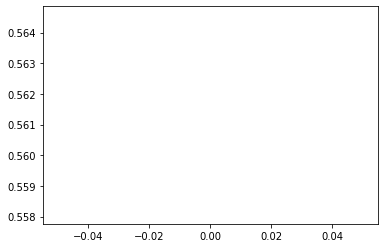

In [22]:
plt.plot(train_loss_record)
plt.plot(valid_loss_record)

## Inference

#### Test set Loading  

    1. Test set is a little bit different since it has no labels, load test_data into mytestDS.
    
    2. No shuffling at dataloader.

In [23]:
""" Inference """
# if config['taks'] == 'inference':
testDS = mytestDS(test_data, all_sents)
# Do not shuffle here
test_dataloader = DataLoader(dataset=testDS, num_workers=2, batch_size=1)

In [25]:
result = []
for idx, data in enumerate(test_dataloader, 0):

    # get data
    s1, s2 = data

    # input
    output = siamese(s1,s2)
    output = output.squeeze(0)

    # feed output into softmax to get prob prediction
    sm = nn.Softmax(dim=1)
    res = sm(output.data)[:,1]
    result += res.data.tolist()

result = pd.DataFrame(result)
print('Inference Done.')

Inference Done.


#### Write down the result

In [27]:
res_path = os.path.join(config['result']['filepath'], config['result']['filename'])
result.to_csv(res_path,header=False,index=False)
print('Result has writtn to', res_path, ', Good Luck!')

Result has writtn to res/result.txt , Good Luck!
